In [1]:
%load_ext sql
%pylab inline
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

figdir = '/home/glandrum/Papers/MolecularTimeSeries/images/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Get assays with an associated document and pchembl_values from the local ChEMBL30 install

In [2]:
%sql postgresql://localhost/chembl_30 \
     drop table if exists IC50_assays

%sql postgresql://localhost/chembl_30 \
select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id, \
    count(distinct(molregno)) cnt,pref_name \
into temporary table IC50_assays \
          from activities \
          join docs using (doc_id) \
          join assays using(assay_id) \
          join target_dictionary as targets using (tid)\
          where pchembl_value is not null  \
          and docs.year is not null \
          and standard_units = 'nM' \
          and data_validity_comment is null \
          group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name) order by cnt desc

Done.
248200 rows affected.


[]

Limit to those with 300-1000 datapoints

 * postgresql://localhost/chembl_30
132 rows affected.


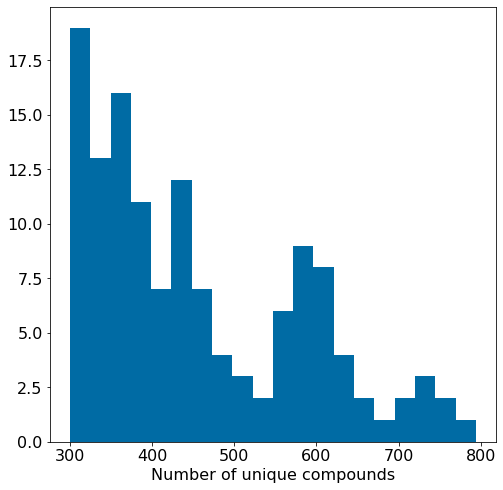

In [3]:
figsize(8,8)
d = %sql select * from IC50_assays where cnt>=300 and cnt<=1000 order by cnt desc;
df = d.DataFrame()
hist(df.cnt,bins=20)
xlabel('Number of unique compounds');

plt.savefig(f'{figdir}/chembl_assays_compound_count.pdf',bbox_inches='tight')


In [4]:
df.head(20)

,assay_id,assay_chembl_id,description,tid,target_chembl_id,cnt,pref_name
0,1641660,CHEMBL3888383,Cell Based Assay: TRKA co-expressed with p75: ...,11902,CHEMBL2815,794,Nerve growth factor receptor Trk-A
1,1528837,CHEMBL3705899,In Vitro Assay: Recombinant human factor D (ex...,105346,CHEMBL2176771,768,Complement factor D
2,1527879,CHEMBL3705123,Inhibiton Assay: Inhibition assay using human ...,11904,CHEMBL2998,749,P2X purinoceptor 3
3,1528786,CHEMBL3706373,Homogeneous Time Resolved Fluorescence Assay: ...,10102,CHEMBL4550,733,5-lipoxygenase activating protein
4,1641435,CHEMBL3888158,PARP Enzyme Inhibition Assay: PARP1 assay was ...,11663,CHEMBL3105,724,Poly [ADP-ribose] polymerase-1
5,1528055,CHEMBL3705362,Mobility-Shift kinase assay: Compounds of the ...,10906,CHEMBL2599,720,Tyrosine-protein kinase SYK
6,1642374,CHEMBL3889097,Functional Assay: The functional activity of c...,103857,CHEMBL1667665,700,Transient receptor potential M8 protein
7,1638439,CHEMBL3881499,Binding affinity to immobilized human TFPI-1al...,115023,CHEMBL3713062,698,Tissue factor pathway inhibitor
8,1998110,CHEMBL4649949,Phenotypic growth assay for Mycobacterium tube...,22226,CHEMBL612545,688,Unchecked
9,1528801,CHEMBL3705476,Spectrophotometric 384 Well Assay: Malonyl CoA...,10608,CHEMBL4829,662,Acetyl-CoA carboxylase 2


In [5]:
aids = df.assay_id.to_list()
achemblids = df.assay_chembl_id.to_list()

len(aids)

132

Generate the intake data catalog file 

In [6]:
yaml=[]
for aid,achemblid in zip(aids,achemblids):
    d = %sql postgresql://localhost/chembl_30 \
select distinct on (cil.chembl_id) cil.chembl_id compound_chembl_id,canonical_smiles, \
        standard_value,standard_units,standard_relation,standard_type,pchembl_value \
          from activities join assays using(assay_id) \
          join compound_structures using(molregno) \
          join chembl_id_lookup cil on (molregno=entity_id and entity_type='COMPOUND') \
          where pchembl_value is not null  \
            and standard_value is not null and standard_units = 'nM' \
            and data_validity_comment is null \
            and assay_id=:aid \
          order by cil.chembl_id;
    df = d.DataFrame()
    df.to_csv(f'./datasets/source_data/assay_{achemblid}.csv.gz',index=False)
    
    minAct = min(df.pchembl_value)
    maxAct = max(df.pchembl_value)
    medAct = np.median(df.pchembl_value)
    actTypes = list(set(df.standard_type))
    if len(actTypes)>1:
        print(f'SKIPPING {achemblid} since it has {len(actTypes)} different activity types.')
        continue
    actType = actTypes[0]
    assayd = %sql postgresql://localhost/chembl_30 \
    select * from assays  \
        where assay_id=:aid
    assayd = dict(assayd[0])
    # quotes in the description cause problems with the yaml parsing
    assayd['description'] = assayd['description'].replace('"','')
    template=f'''  {achemblid}:
    description: "Assay {achemblid}: {assayd['description']}"
    args:
      filename: '{{{{ CATALOG_DIR }}}}/source_data/assay_{achemblid}.csv.gz'
      smilesColumn: canonical_smiles
    metadata:
      url: https://www.ebi.ac.uk/chembl/assay_report_card/{achemblid}/
      source: ChEMBL_30
      activity_type: {actType}
      min pchembl_value: {minAct:.2f}
      max pchembl_value: {maxAct:.2f}
      median pchembl_value: {medAct:.2f}
    driver: intake_rdkit.smiles.SmilesSource
'''
    yaml.append(template)
print('\n'.join(yaml))
with open('./datasets/assays.yaml','w+') as outf:
    header='''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collection of datasets with pchembl_values for bioactivity prediction.

    Each row includes the reported value. Only values without data_validity_comments are included
    
sources:'''
    print(header,file=outf)
    print('\n'.join(yaml),file=outf)
    

794 rows affected.
1 rows affected.
766 rows affected.
1 rows affected.
748 rows affected.
1 rows affected.
733 rows affected.
1 rows affected.
724 rows affected.
1 rows affected.
720 rows affected.
1 rows affected.
700 rows affected.
1 rows affected.
698 rows affected.
1 rows affected.
688 rows affected.
1 rows affected.
662 rows affected.
1 rows affected.
653 rows affected.
1 rows affected.
643 rows affected.
1 rows affected.
641 rows affected.
1 rows affected.
641 rows affected.
1 rows affected.
630 rows affected.
1 rows affected.
620 rows affected.
1 rows affected.
620 rows affected.
1 rows affected.
618 rows affected.
1 rows affected.
617 rows affected.
1 rows affected.
607 rows affected.
1 rows affected.
601 rows affected.
1 rows affected.
600 rows affected.
1 rows affected.
597 rows affected.
1 rows affected.
596 rows affected.
1 rows affected.
587 rows affected.
1 rows affected.
587 rows affected.
1 rows affected.
584 rows affected.
1 rows affected.
582 rows affected.
1 rows af